In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, cut_tree, fcluster, linkage as sch_linkage
from ISLP.cluster import compute_linkage

In [2]:
# function for computing within group sum of squares for clustering
def WithinGroupSumOfSquares(X, labels):
    k = np.unique(labels).shape[0]
    centroids = np.concatenate([np.mean(X[labels == group], axis=0) for group in range(k)], axis=0)\
        .reshape(k,X.shape[1])
    return np.sum(np.sum((X - centroids[labels])**2, axis=1))

### Exploration and Preprocessing

In [3]:
# read in the data
data_file = os.path.join(os.getcwd(), 'data', 'raw', 'Hospital_Financial_Quarterly_Aggregate_Report_20250520.csv')
hospital_data_dirty = pd.read_csv(data_file)
for d in hospital_data_dirty.dtypes.unique():
    print(f"Columns of type {d}:")
    print(hospital_data_dirty.select_dtypes(d).columns)
print(hospital_data_dirty.head().iloc[:, :10])

Columns of type int64:
Index(['License_Number', 'Year', 'Quarter', 'Licensed_Beds',
       'Acute_Care_Medicare_Discharges', 'Acute_Care_Medicaid_Discharges',
       'Acute_Care_Self_Pay_Discharges', 'Acute_Care_Commercial_Discharges',
       'Acute_Care_Other_Discharges', 'Acute_Care_Total_Discharges',
       ...
       'Operating_Margin', 'Net_Non_Operating_Gains_Losses', 'Tax_Subsidies',
       'Gross_Total_Margin', 'Gross_Accounts_Receivable_Medicare',
       'Gross_Accounts_Receivable_Medicaid',
       'Gross_Accounts_Receivable_Self_Pay',
       'Gross_Accounts_Receivable_Commercial',
       'Gross_Accounts_Receivable_Other', 'Total_Gross_Accounts_Receivable'],
      dtype='object', length=159)
Columns of type object:
Index(['Hospital_Name', 'City'], dtype='object')
Columns of type float64:
Index(['Professional_Fee_Expense', 'Casemix Index'], dtype='object')
   License_Number                                     Hospital_Name     City  \
0              42         Shriners Hospital

In [4]:
# exploration of missing data
percent_col_data_missing = 100 * hospital_data_dirty.isna().sum(axis=0) / hospital_data_dirty.shape[0]
percent_col_data_missing[percent_col_data_missing.values.astype(bool)]

Professional_Fee_Expense    66.197183
dtype: float64

In [5]:
categorical_columns = ['License_Number', 'Hospital_Name', 'City', 'Quarter']
# columns 76 on are float, previous are int
float_cols = hospital_data_dirty.columns[76:]
int_cols = set(hospital_data_dirty.columns[:76]).difference(categorical_columns)
type_dict = {col:"int" for col in int_cols}
type_dict.update({col:"float" for col in float_cols})
type_dict.update({col:"category" for col in categorical_columns})
#retype and filter dataset
hospital_data_filtered = hospital_data_dirty.astype(type_dict)
hospital_data_filtered = hospital_data_filtered.drop(columns=categorical_columns + ['Professional_Fee_Expense'])

In [6]:
print(f"Number of hospital-quarter-year records: {hospital_data_dirty.shape[0]}")
print(f"Number of unique Hospitals: {hospital_data_dirty['Hospital_Name'].unique().shape[0]}")
print(f"Years represented: {hospital_data_filtered['Year'].min()} - {hospital_data_filtered['Year'].max()}")

Number of hospital-quarter-year records: 2840
Number of unique Hospitals: 106
Years represented: 2018 - 2025


In [7]:
# are any remaining columns zero variance?
hospital_data_filtered.columns[np.isclose(hospital_data_filtered.apply(np.var, axis=0).values, 0.0)]

Index([], dtype='object')

### PCA

In [8]:
# create standard scaled data and do PCA
scaler = StandardScaler()
hospital_data_scaled = scaler.fit_transform(hospital_data_filtered)

U, s, Vt = np.linalg.svd(hospital_data_scaled, full_matrices=False)

pve = s**2 / np.sum(s**2)
cpve = np.cumsum(pve)
cpve_thresh = np.where(cpve > 0.8)[0][0]+1 # num components to explain 80% variance
pc1 = pd.Series(Vt[0,:].reshape(-1), index=hospital_data_filtered.columns)

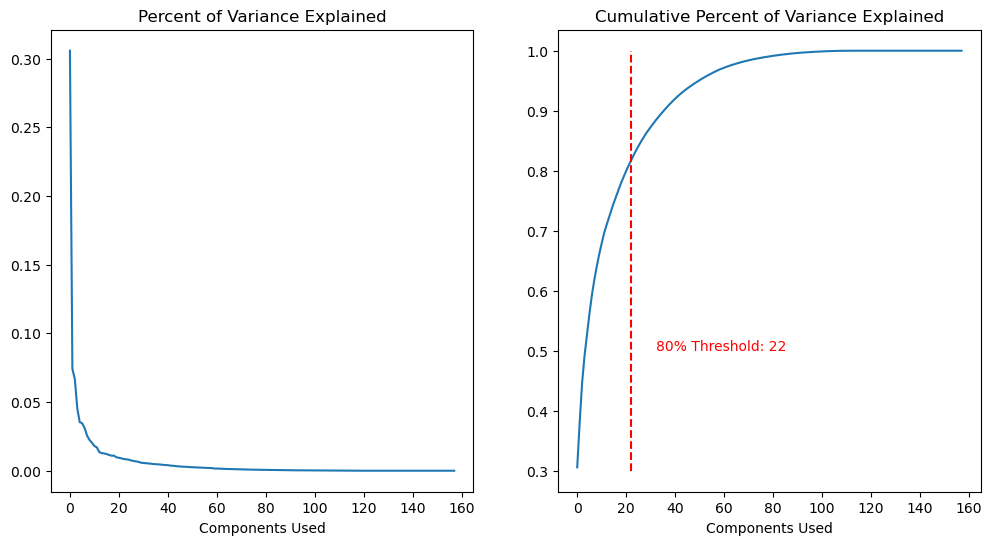

In [9]:
# Scree Plots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
axes[0].plot(pve)
axes[1].plot(cpve)
axes[0].set_title("Percent of Variance Explained")
axes[0].set_xlabel("Components Used")
axes[1].set_title("Cumulative Percent of Variance Explained")
axes[1].set_xlabel("Components Used")
axes[1].vlines(x=cpve_thresh, ymin=0.3, ymax=1, colors='red', linestyles='--')
axes[1].text(x=cpve_thresh+10, y=0.5, s=f"80% Threshold: {cpve_thresh}", color='red')
out_file = os.path.join(os.getcwd(), 'data', 'pca', 'scree_plots.png')
plt.savefig(out_file)
plt.show()

Total_Revenue                       0.141600
Total_Contractuals                  0.139640
Acute_Contractuals_Total            0.139077
Acute_Total_Inpatient_Revenue       0.138149
Acute_Care_Total_Patient_Days       0.135282
Total_Patient_Days                  0.134629
Total_Operating_Expenses            0.132543
Licensed_Beds                       0.132491
Acute_Total_Outpatient_Revenue      0.132239
Total_Medicare_Revenue              0.132114
Total_Payroll                       0.131535
Total_Medicare_Contractuals         0.130421
Acute_Contractuals_Medicare         0.129898
Facility_Payroll                    0.129580
Total_Discharges                    0.129532
Acute_Medicare_Inpatient_Revenue    0.129514
Acute_Care_Total_Discharges         0.129038
Total_Paid_Hours                    0.128839
Facility_Paid_Hours                 0.128111
Acute_Care_Medicare_Patient_Days    0.128105
dtype: float64


C:\Users\ellin\AppData\Local\Temp\ipykernel_23440\259349631.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pc1_abs_loadings = pc1[pc1_sort_ind].apply(np.abs)
C:\Users\ellin\AppData\Local\Temp\ipykernel_23440\259349631.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(pc1[pc1_sort_ind][:20]) # top 20


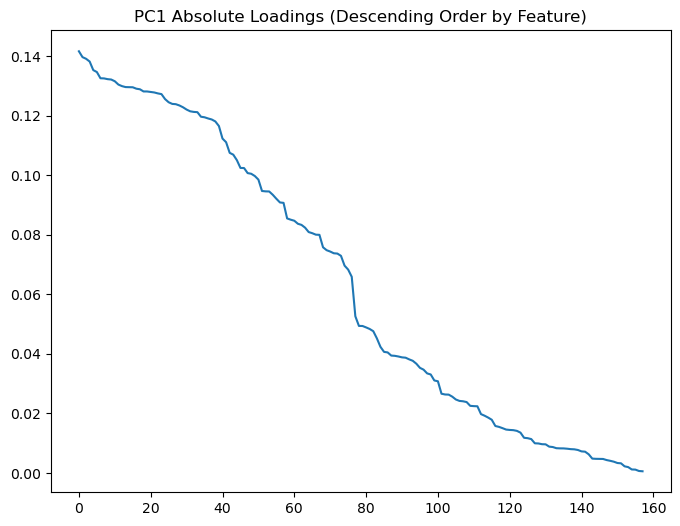

In [10]:
# which fields have the highest loadings in PC1?
pc1_sort_ind = pc1.apply(np.abs).argsort()[::-1]
pc1_abs_loadings = pc1[pc1_sort_ind].apply(np.abs)
print(pc1[pc1_sort_ind][:20]) # top 20
plt.figure(figsize=(8, 6))
plt.plot(pc1_abs_loadings.values)
plt.title("PC1 Absolute Loadings (Descending Order by Feature)")
out_file = os.path.join(os.getcwd(), 'data', 'pca', 'absolute_loadings_vs_feature_ordered_desc.png')
plt.savefig(out_file)
plt.show()

## Agglomerative Clustering

In [11]:
# subset data for plotting full dendograms for illustration
dendogram_subset_size = 100
rng = np.random.default_rng(123)
dendogram_sample_idx = rng.choice(np.arange(0, hospital_data_scaled.shape[0]),
                                  size = dendogram_subset_size, replace=False)

#other set up
corD = 1 - np.corrcoef(hospital_data_scaled)

n_cluster_grid = np.arange(2, 8)

data_pca = PCA(n_components=2).fit_transform(hospital_data_scaled) # for plots

record_ids = hospital_data_dirty['Hospital_Name'] + ' LicNo_' + hospital_data_dirty['License_Number'].astype("str")
record_hosp_name = hospital_data_dirty['Hospital_Name']
record_licno = hospital_data_dirty['License_Number']

dendogram_samples = hospital_data_scaled[dendogram_sample_idx, :]
dendogram_ticks = record_hosp_name[dendogram_sample_idx].to_list()


all_centroids = {}

### Single Linkage

Cluster Membership for 2 Clusters:  [2839, 1]
Cluster Membership for 3 Clusters:  [2838, 1, 1]
Cluster Membership for 4 Clusters:  [2837, 1, 1, 1]
Cluster Membership for 5 Clusters:  [2836, 1, 1, 1, 1]
Cluster Membership for 6 Clusters:  [2835, 1, 1, 1, 1, 1]
Cluster Membership for 7 Clusters:  [2834, 1, 1, 1, 1, 1, 1]


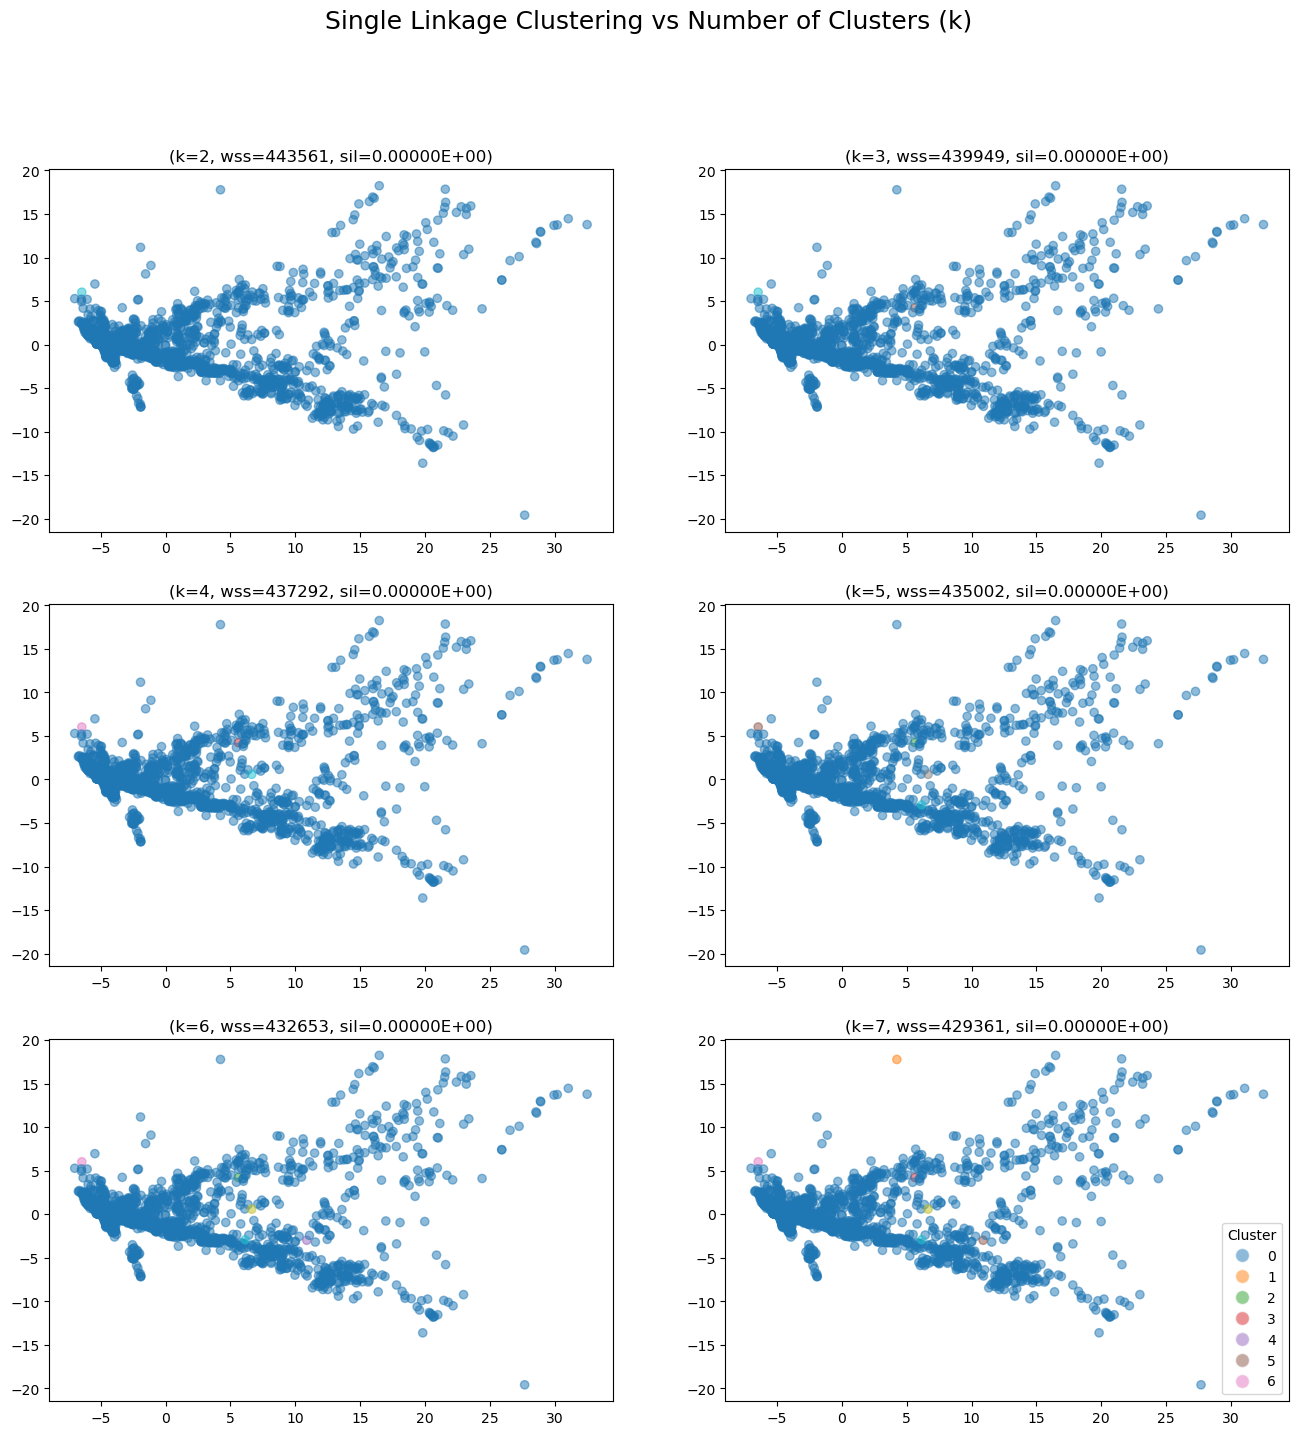

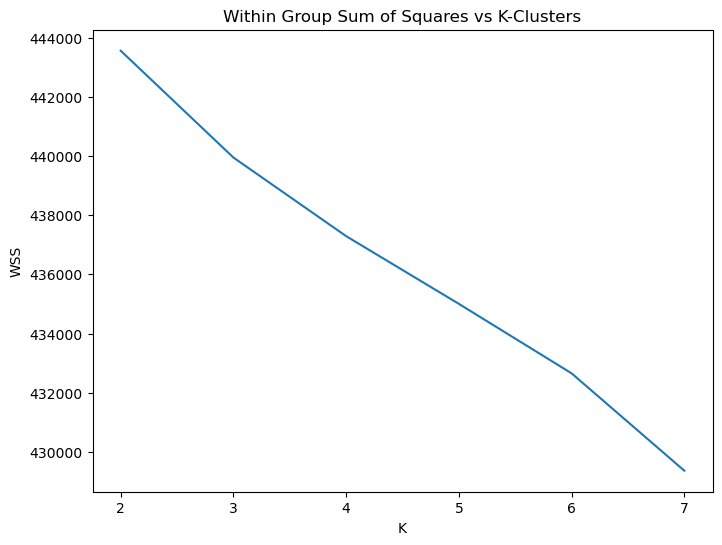

In [12]:
hc_single = AgglomerativeClustering(distance_threshold=0,
                                  n_clusters=None,
                                  linkage='single')
hc_single.fit(hospital_data_scaled)
linkage_single = compute_linkage(hc_single)

# metric setup
wss = np.empty_like(n_cluster_grid)
sil_scores = np.empty_like(n_cluster_grid)
labels_by_n = np.empty(shape=(n_cluster_grid.shape[0], hospital_data_scaled.shape[0]), dtype=np.int32)
cluster_centroids_by_n = {}
cluster_membership_by_n = {}

# plot setup
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16,16))
colors = plt.get_cmap("tab10", 10)
colors_list = [colors(i) for i in range(colors.N)]
cluster_names = list(range(n_cluster_grid[-1]))
legend_handles = [Line2D([0], [0], marker='o', color='w', alpha=0.5, markerfacecolor=color, markersize=10, label=cname) 
                  for cname, color in zip(cluster_names, colors_list)]

# compare different cuts
for i, n in enumerate(n_cluster_grid):
    labels_by_n[i, :] = cut_tree(linkage_single, n_clusters=n).T
    sil_scores[i] = silhouette_score(hospital_data_scaled, labels_by_n[i, :], metric='euclidean')
    wss[i] = WithinGroupSumOfSquares(hospital_data_scaled, labels_by_n[i, :])
    cluster_centroids_by_n[n] = np.concatenate(
        [np.mean(hospital_data_scaled[labels_by_n[i, :] == group], axis=0) for group in range(n)], axis=0)\
            .reshape(n,hospital_data_scaled.shape[1])
    cluster_membership_by_n[n] = [labels_by_n[i, :][labels_by_n[i, :] == group].shape[0] for group in range(n)]
    print(f'Cluster Membership for {n} Clusters: ', cluster_membership_by_n[n])
    # plot clusters in pca space
    axes[i // 2, i % 2].scatter(x=data_pca[:, 0], y = data_pca[:, 1], c = labels_by_n[i, :],
                                cmap=colors, alpha=0.5)
    axes[i // 2, i % 2].set_title(f'(k={n}, wss={wss[i]}, sil={sil_scores[i]:.5E})')
plt.legend(handles=legend_handles, title='Cluster')
fig.suptitle("Single Linkage Clustering vs Number of Clusters (k)", fontsize=18)
out_file = os.path.join(os.getcwd(), 'data', 'hierarchical_clustering', 'single_linkage_clusters.png')
plt.savefig(out_file)
plt.show()

# wss vs number of clusters
plt.figure(figsize=(8,6))
plt.plot(wss)
plt.title("Within Group Sum of Squares vs K-Clusters")
plt.xticks(ticks=range(len(n_cluster_grid)), labels=n_cluster_grid)
plt.xlabel("K")
plt.ylabel("WSS")
out_file = os.path.join(os.getcwd(), 'data', 'hierarchical_clustering', 'single_linkage_wss_vs_k.png')
plt.savefig(out_file)
plt.show()

all_centroids['single'] = cluster_centroids_by_n

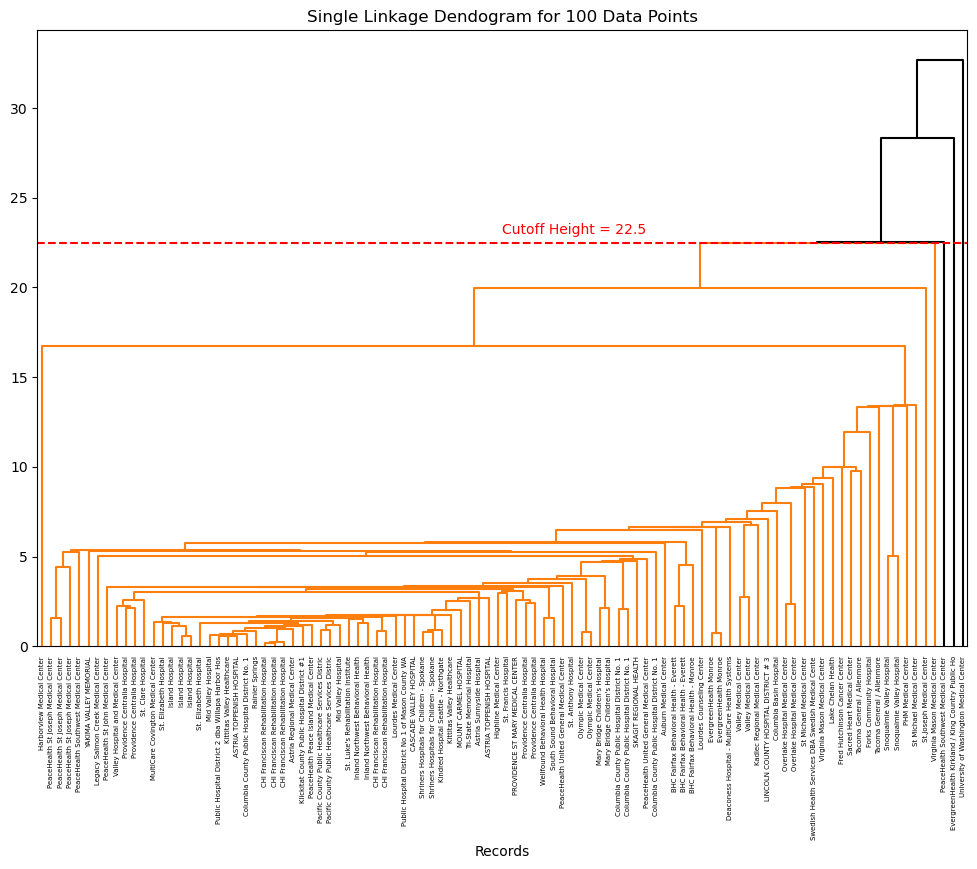

In [13]:
# plot full dendogram with data subset
hc_single_part = AgglomerativeClustering(distance_threshold=0,
                                  n_clusters=None,
                                  linkage='single')
hc_single_part.fit(dendogram_samples)
linkage_single_part = compute_linkage(hc_single_part)
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
dendrogram(linkage_single_part,
           ax=ax,
           color_threshold=22.5,
           above_threshold_color='black',
           labels=dendogram_ticks)
ax.set_title(f"Single Linkage Dendogram for {dendogram_subset_size} Data Points")
ax.set_xlabel("Records")
ax.hlines(y=22.5, xmin=ax.get_xlim()[0], xmax=ax.get_xlim()[1], colors='red', linestyles='--')
ax.text(s="Cutoff Height = 22.5", x=np.mean(ax.get_xlim()), y=23, color="red")
out_file = os.path.join(os.getcwd(), 'data', 'hierarchical_clustering', 'single_linkage_dendogram.png')
plt.savefig(out_file, bbox_inches="tight")
plt.show()

### Complete Linkage

Cluster Membership for 2 Clusters:  [2839, 1]
Cluster Membership for 3 Clusters:  [2838, 1, 1]
Cluster Membership for 4 Clusters:  [2828, 10, 1, 1]
Cluster Membership for 5 Clusters:  [2827, 10, 1, 1, 1]
Cluster Membership for 6 Clusters:  [2819, 10, 8, 1, 1, 1]
Cluster Membership for 7 Clusters:  [2819, 1, 9, 8, 1, 1, 1]


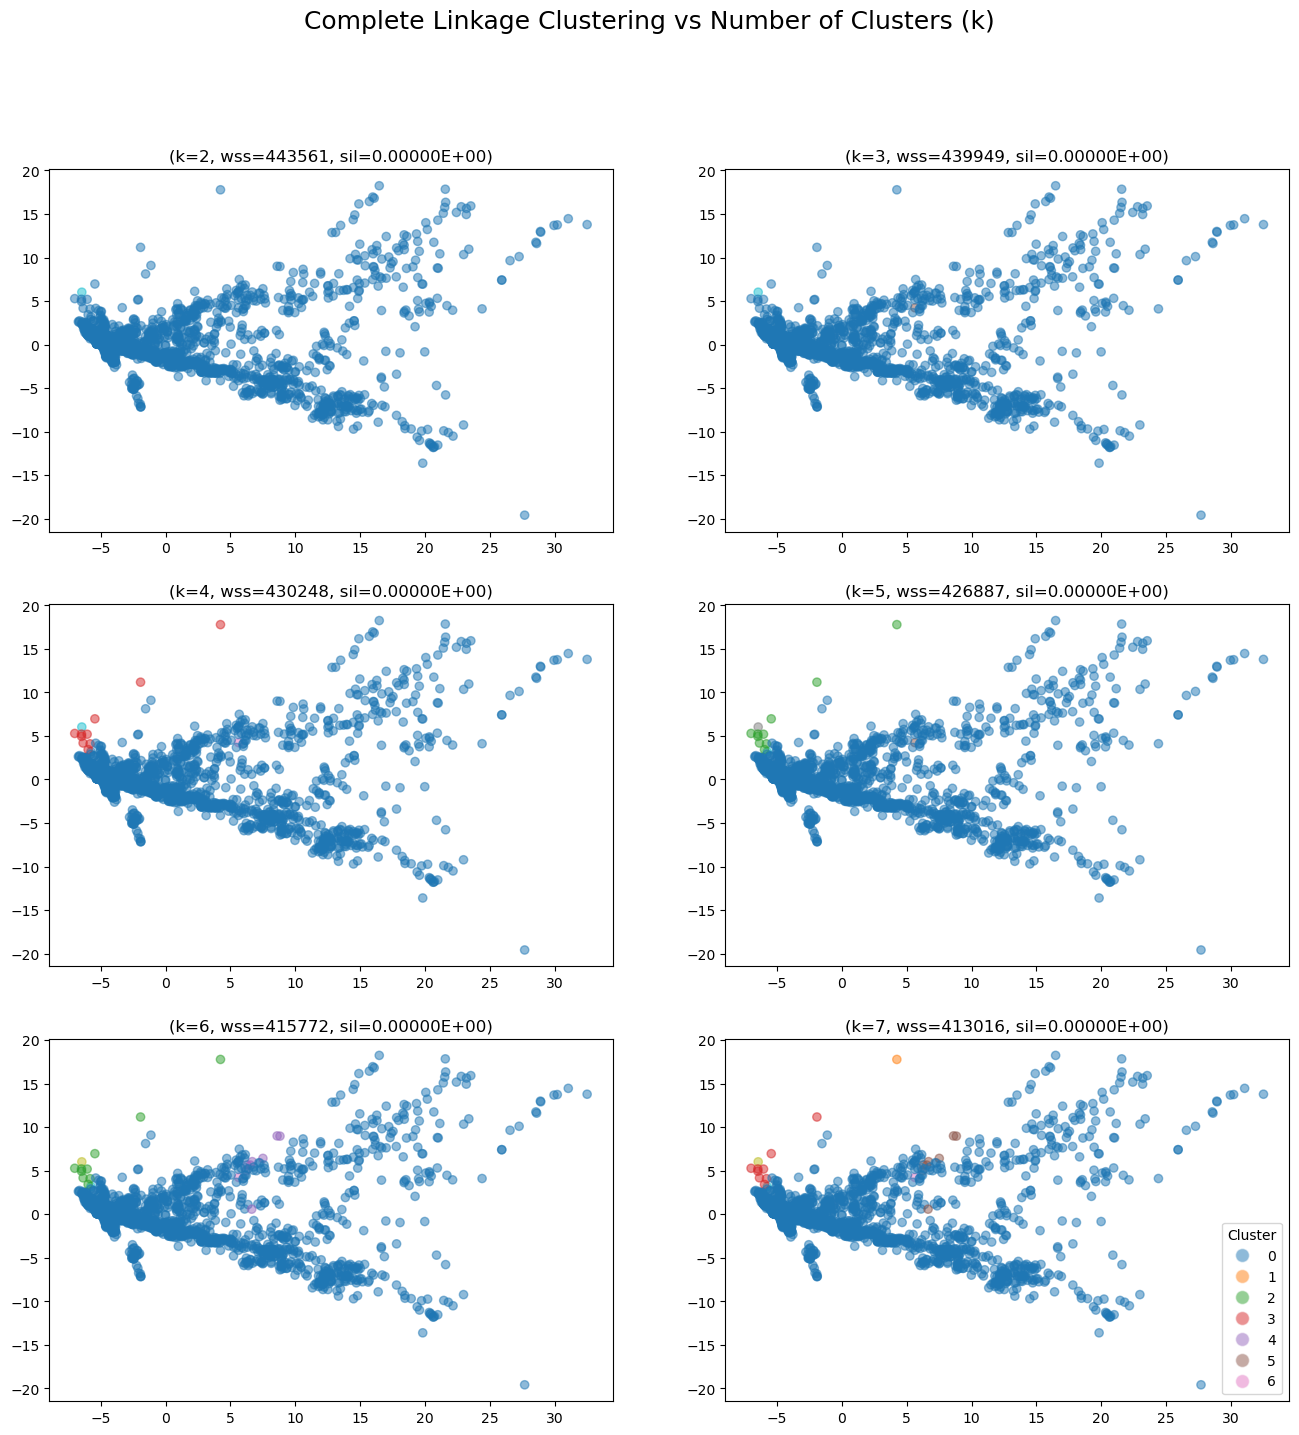

Hospitals in Cluster 2: 
1891                            YAKIMA VALLEY MEMORIAL
1984                            YAKIMA VALLEY MEMORIAL
2077                            YAKIMA VALLEY MEMORIAL
2171                            YAKIMA VALLEY MEMORIAL
2304    Confluence Health: Central Washington Hospital
2453                            YAKIMA VALLEY MEMORIAL
2545                            YAKIMA VALLEY MEMORIAL
2640                            YAKIMA VALLEY MEMORIAL
Name: Hospital_Name, dtype: object
Hospitals in Cluster 4: 
2128    Snoqualmie Valley Hospital
Name: Hospital_Name, dtype: object


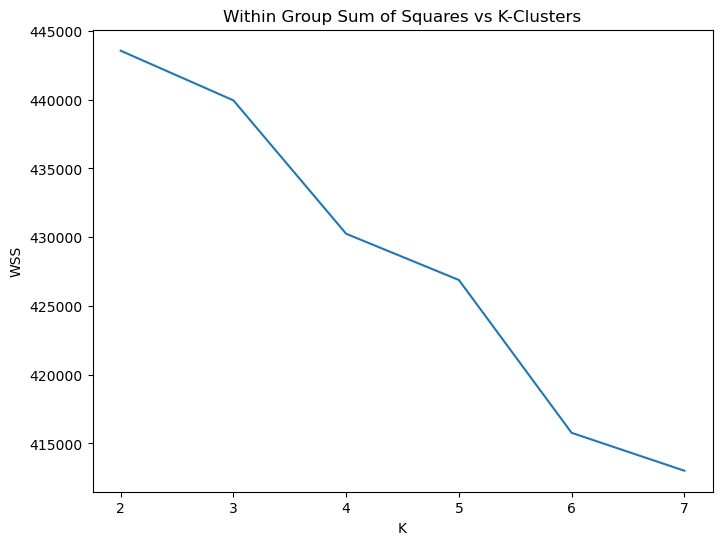

In [ ]:
hc_complete = AgglomerativeClustering(distance_threshold=0,
                                  n_clusters=None,
                                  linkage='complete')
hc_complete.fit(hospital_data_scaled)
linkage_complete = compute_linkage(hc_complete)

# metric setup
wss = np.empty_like(n_cluster_grid)
sil_scores = np.empty_like(n_cluster_grid)
labels_by_n = np.empty(shape=(n_cluster_grid.shape[0], hospital_data_scaled.shape[0]), dtype=np.int32)
cluster_centroids_by_n = {}
cluster_membership_by_n = {}

# plot setup
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16,16))
colors = plt.get_cmap("tab10", 10)
colors_list = [colors(i) for i in range(colors.N)]
cluster_names = list(range(n_cluster_grid[-1]))
legend_handles = [Line2D([0], [0], marker='o', color='w', alpha=0.5, markerfacecolor=color, markersize=10, label=cname) 
                  for cname, color in zip(cluster_names, colors_list)]

# compare different cuts
for i, n in enumerate(n_cluster_grid):
    labels_by_n[i, :] = cut_tree(linkage_complete, n_clusters=n).T
    sil_scores[i] = silhouette_score(hospital_data_scaled, labels_by_n[i, :], metric='euclidean')
    wss[i] = WithinGroupSumOfSquares(hospital_data_scaled, labels_by_n[i, :])
    cluster_centroids_by_n[n] = np.concatenate(
        [np.mean(hospital_data_scaled[labels_by_n[i, :] == group], axis=0) for group in range(n)], axis=0)\
            .reshape(n,hospital_data_scaled.shape[1])
    cluster_membership_by_n[n] = [labels_by_n[i, :][labels_by_n[i, :] == group].shape[0] for group in range(n)]
    print(f'Cluster Membership for {n} Clusters: ', cluster_membership_by_n[n])
    # plot clusters in pca space
    axes[i // 2, i % 2].scatter(x=data_pca[:, 0], y = data_pca[:, 1], c = labels_by_n[i, :],
                                cmap=colors, alpha=0.5)
    axes[i // 2, i % 2].set_title(f'(k={n}, wss={wss[i]}, sil={sil_scores[i]:.5E})')
plt.legend(handles=legend_handles, title='Cluster')
fig.suptitle("Complete Linkage Clustering vs Number of Clusters (k)", fontsize=18)
out_file = os.path.join(os.getcwd(), 'data', 'hierarchical_clustering', 'complete_linkage_clusters.png')
plt.savefig(out_file)
plt.show()

# print names of hospitals in two outlier groups
# cluster 2: Centroid show a larger hospitals
print("Hospitals in Cluster 2: ")
print(record_hosp_name[labels_by_n[6 - 2, :] == 2])

# cluster 4: centroid shows somewhat smaller hospitals with a focus on Swing Beds and SNF
print("Hospitals in Cluster 4: ")
print(record_hosp_name[labels_by_n[6 - 2, :] == 6])

# wss vs number of clusters
plt.figure(figsize=(8,6))
plt.plot(wss)
plt.title("Within Group Sum of Squares vs K-Clusters")
plt.xticks(ticks=range(len(n_cluster_grid)), labels=n_cluster_grid)
plt.xlabel("K")
plt.ylabel("WSS")
out_file = os.path.join(os.getcwd(), 'data', 'hierarchical_clustering', 'complete_linkage_wss_vs_k.png')
plt.savefig(out_file)
plt.show()

all_centroids['complete'] = cluster_centroids_by_n

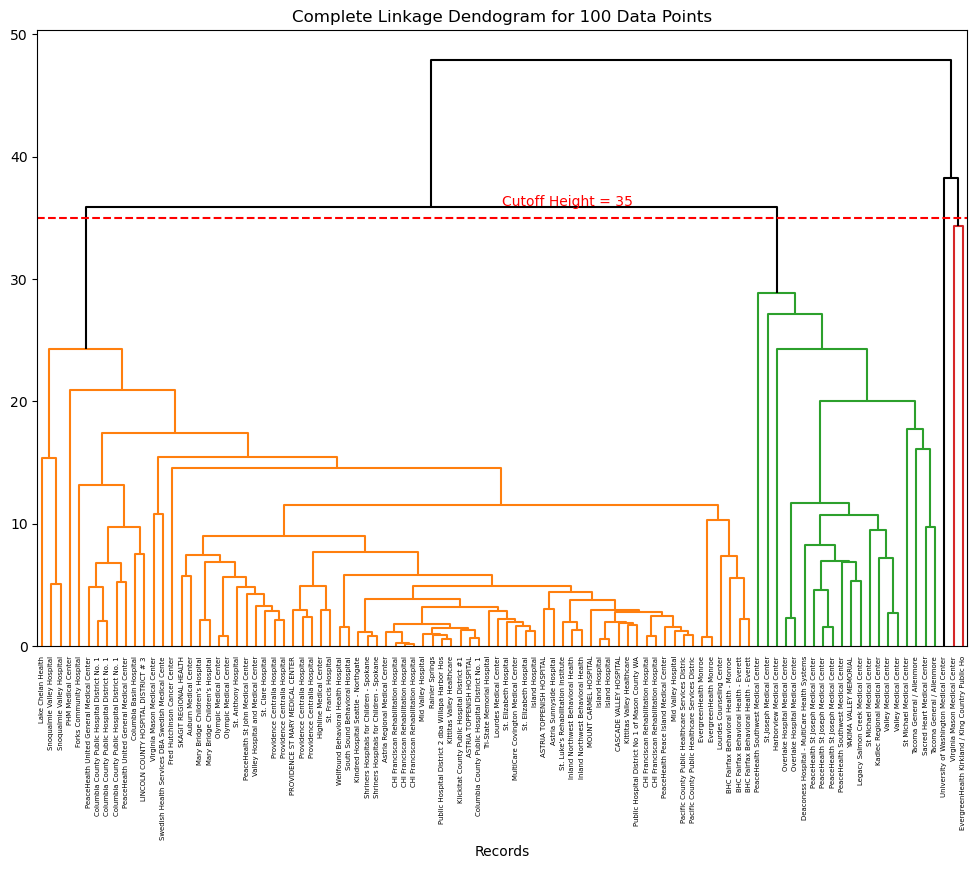

In [15]:
# plot full dendogram with data subset
hc_complete_part = AgglomerativeClustering(distance_threshold=0,
                                  n_clusters=None,
                                  linkage='complete')
hc_complete_part.fit(dendogram_samples)
linkage_complete_part = compute_linkage(hc_complete_part)
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
dendrogram(linkage_complete_part,
           ax=ax,
           color_threshold=35,
           above_threshold_color='black',
           labels=dendogram_ticks)
ax.set_title(f"Complete Linkage Dendogram for {dendogram_subset_size} Data Points")
ax.set_xlabel("Records")
ax.hlines(y=35, xmin=ax.get_xlim()[0], xmax=ax.get_xlim()[1], colors='red', linestyles='--')
ax.text(s="Cutoff Height = 35", x=np.mean(ax.get_xlim()), y=36, color="red")
out_file = os.path.join(os.getcwd(), 'data', 'hierarchical_clustering', 'complete_linkage_dendogram.png')
plt.savefig(out_file, bbox_inches="tight")
plt.show()

In [16]:
#Print 10 most similar and 10 most dissimlar normalized features for two hospitals each from orange and green group
# orange group choices: Shriners Hospitals for Children - Spokane, Kindred Hospital Seattle - Northgate
# green group choices YAKIMA VALLEY MEMORIAL, Legacy Salmon Creek Medical Center

def CompareHospitals(hospital, other, hospital_series, other_series, ignore=None):
    if not isinstance(hospital_series, pd.Series):
        raise TypeError(f"Expected series, not {type(hospital_series).__name__}")
    elif not isinstance(other_series, pd.Series):
        raise TypeError(f"Expected series, not {type(other_series).__name__}")
    differences = np.empty(shape=len(hospital_series), dtype=np.float64)
    for i, feature in enumerate(hospital_series.index):
        differences[i] = float(hospital_series[feature]) - float(other_series[feature])
    abs_diff = np.abs(differences)
    sort_index = np.argsort(abs_diff)
    differences = differences[sort_index]
    comparison_features = hospital_series.index[sort_index]
    return pd.DataFrame({'feature':comparison_features,
                         'hosp1 - hosp2':differences,
                         'hosp1': hospital_series.values[sort_index],
                         'hosp2': other_series.values[sort_index]})

# really need to worry about quarters, but all the hospitals with multiple quarters in the subset were grouped
from itertools import product as cartesian_product
comparison_choices = ['Shriners Hospitals for Children - Spokane', 'Kindred Hospital Seattle - Northgate',
                      'YAKIMA VALLEY MEMORIAL', 'Legacy Salmon Creek Medical Center']
hospitals_to_compare = []
for choice in comparison_choices:
    hospitals_to_compare.append(hospital_data_dirty\
                                .iloc[dendogram_sample_idx, :]\
                                    .loc[hospital_data_dirty['Hospital_Name'] == choice].head(1))

hospitals_to_compare = pd.concat(hospitals_to_compare, axis=0)

hosp_pairs = sorted(list(set(tuple(sorted(t)) for t in cartesian_product(comparison_choices, comparison_choices))))

for pair in hosp_pairs:
    if (pair[0] == pair[1]):
        continue
    pair_series = (hospitals_to_compare.loc[hospitals_to_compare['Hospital_Name'] == pair[0]]\
                    .drop(columns=['License_Number', 'Hospital_Name', 'City', 'Quarter', 'Professional_Fee_Expense'])\
                    .squeeze(),
                   hospitals_to_compare.loc[hospitals_to_compare['Hospital_Name'] == pair[1]]\
                    .drop(columns=['License_Number', 'Hospital_Name', 'City', 'Quarter', 'Professional_Fee_Expense'])\
                    .squeeze())
    comparison_df = CompareHospitals(*pair, *pair_series)
    print(f"\n\n\nComparing [{pair[0]}] to [{pair[1]}], selected quarters")
    print("Most similar features (ordered most to least similar)")
    print(comparison_df.head(10))
    print("Most different features (ordered most to least different)")
    print(comparison_df.tail(10).iloc[::-1])




Comparing [Kindred Hospital Seattle - Northgate] to [Legacy Salmon Creek Medical Center], selected quarters
Most similar features (ordered most to least similar)
                            feature  hosp1 - hosp2  hosp1  hosp2
0  Acute_Care_Commercial_Discharges            0.0    0.0    0.0
1    Acute_Care_Self_Pay_Discharges            0.0    0.0    0.0
2        Swing_Bed_Total_Discharges            0.0    0.0    0.0
3        Swing_Bed_Other_Discharges            0.0    0.0    0.0
4   Swing_Bed_Commercial_Discharges            0.0    0.0    0.0
5     Swing_Bed_Self_Pay_Discharges            0.0    0.0    0.0
6     Swing_Bed_Medicaid_Discharges            0.0    0.0    0.0
7    Swing_Bed_Medicare_Discharges1            0.0    0.0    0.0
8           SNF_Medicare_Discharges            0.0    0.0    0.0
9           SNF_Medicaid_Discharges            0.0    0.0    0.0
Most different features (ordered most to least different)
                             feature  hosp1 - hosp2  hosp1    

### Average Linkage

Cluster Membership for 2 Clusters:  [2839, 1]
Cluster Membership for 3 Clusters:  [2838, 1, 1]
Cluster Membership for 4 Clusters:  [2837, 1, 1, 1]
Cluster Membership for 5 Clusters:  [2836, 1, 1, 1, 1]
Cluster Membership for 6 Clusters:  [2835, 1, 1, 1, 1, 1]
Cluster Membership for 7 Clusters:  [2834, 1, 1, 1, 1, 1, 1]


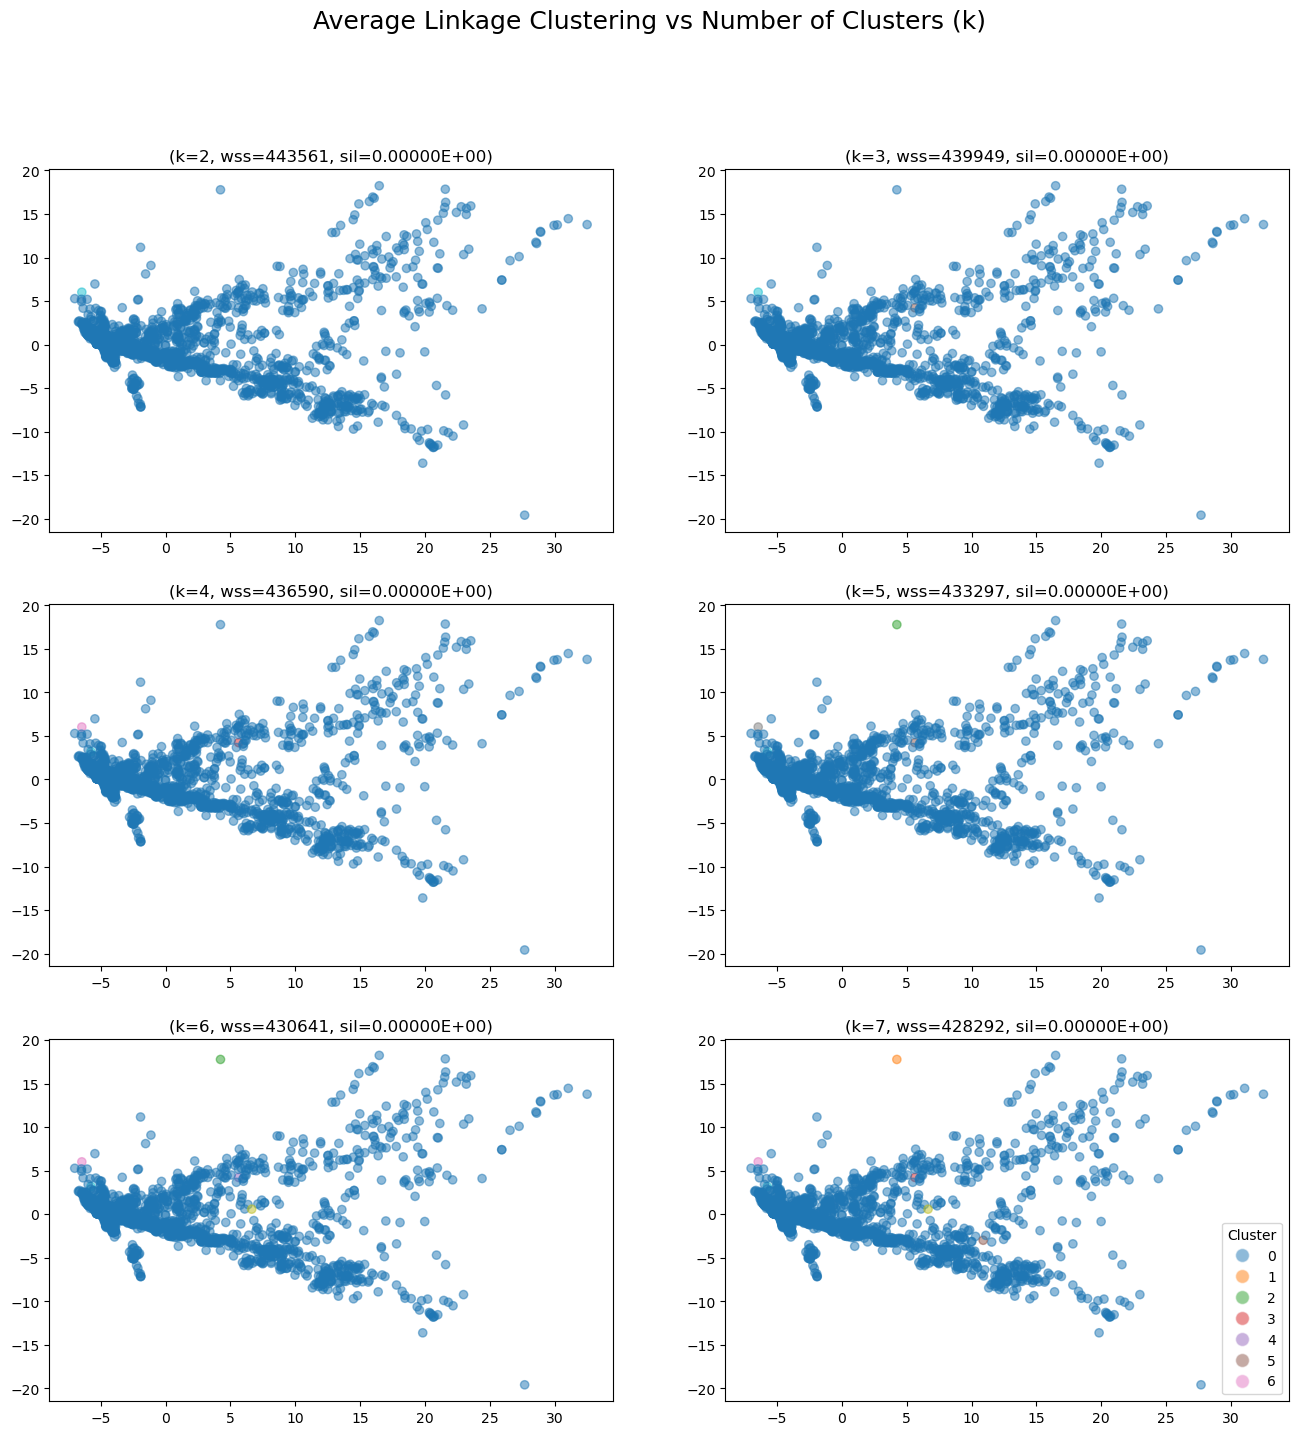

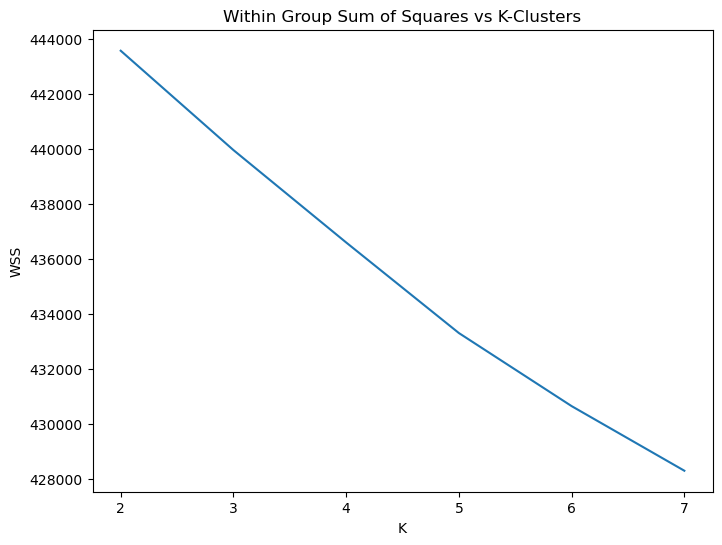

In [17]:
hc_avg = AgglomerativeClustering(distance_threshold=0,
                                  n_clusters=None,
                                  linkage='average')
hc_avg.fit(hospital_data_scaled)
linkage_avg = compute_linkage(hc_avg)

# metric setup
wss = np.empty_like(n_cluster_grid)
sil_scores = np.empty_like(n_cluster_grid)
labels_by_n = np.empty(shape=(n_cluster_grid.shape[0], hospital_data_scaled.shape[0]), dtype=np.int32)
cluster_centroids_by_n = {}
cluster_membership_by_n = {}

# plot setup
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16,16))
colors = plt.get_cmap("tab10", 10)
colors_list = [colors(i) for i in range(colors.N)]
cluster_names = list(range(n_cluster_grid[-1]))
legend_handles = [Line2D([0], [0], marker='o', color='w', alpha=0.5, markerfacecolor=color, markersize=10, label=cname) 
                  for cname, color in zip(cluster_names, colors_list)]

# compare different cuts
for i, n in enumerate(n_cluster_grid):
    labels_by_n[i, :] = cut_tree(linkage_avg, n_clusters=n).T
    sil_scores[i] = silhouette_score(hospital_data_scaled, labels_by_n[i, :], metric='euclidean')
    wss[i] = WithinGroupSumOfSquares(hospital_data_scaled, labels_by_n[i, :])
    cluster_centroids_by_n[n] = np.concatenate(
        [np.mean(hospital_data_scaled[labels_by_n[i, :] == group], axis=0) for group in range(n)], axis=0)\
            .reshape(n,hospital_data_scaled.shape[1])
    cluster_membership_by_n[n] = [labels_by_n[i, :][labels_by_n[i, :] == group].shape[0] for group in range(n)]
    print(f'Cluster Membership for {n} Clusters: ', cluster_membership_by_n[n])
    # plot clusters in pca space
    axes[i // 2, i % 2].scatter(x=data_pca[:, 0], y = data_pca[:, 1], c = labels_by_n[i, :],
                                cmap=colors, alpha=0.5)
    axes[i // 2, i % 2].set_title(f'(k={n}, wss={wss[i]}, sil={sil_scores[i]:.5E})')
plt.legend(handles=legend_handles, title='Cluster')
fig.suptitle("Average Linkage Clustering vs Number of Clusters (k)", fontsize=18)
out_file = os.path.join(os.getcwd(), 'data', 'hierarchical_clustering', 'avg_linkage_clusters.png')
plt.savefig(out_file)
plt.show()

# wss vs number of clusters
plt.figure(figsize=(8,6))
plt.plot(wss)
plt.title("Within Group Sum of Squares vs K-Clusters")
plt.xticks(ticks=range(len(n_cluster_grid)), labels=n_cluster_grid)
plt.xlabel("K")
plt.ylabel("WSS")
out_file = os.path.join(os.getcwd(), 'data', 'hierarchical_clustering', 'avg_linkage_wss_vs_k.png')
plt.savefig(out_file)
plt.show()

all_centroids['average'] = cluster_centroids_by_n

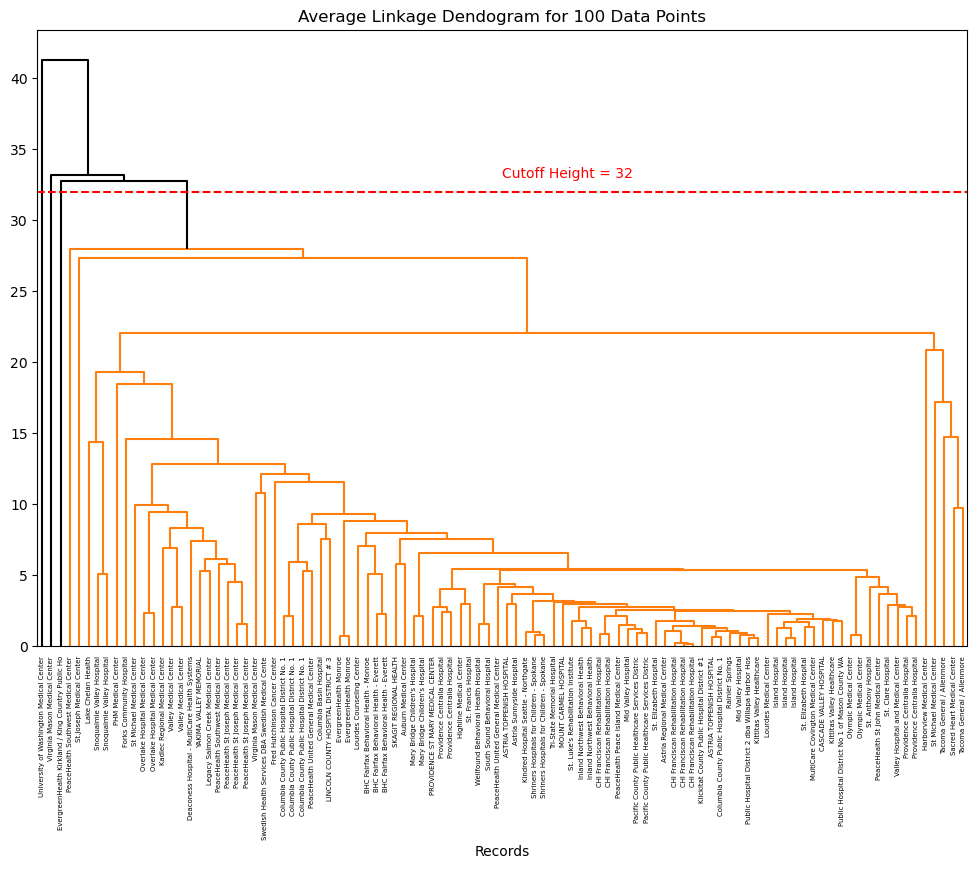

In [18]:
# plot full dendogram with data subset
hc_avg_part = AgglomerativeClustering(distance_threshold=0,
                                  n_clusters=None,
                                  linkage='average')
hc_avg_part.fit(dendogram_samples)
linkage_avg_part = compute_linkage(hc_avg_part)
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
dendrogram(linkage_avg_part,
           ax=ax,
           color_threshold=32,
           above_threshold_color='black',
           labels=dendogram_ticks)
ax.set_title(f"Average Linkage Dendogram for {dendogram_subset_size} Data Points")
ax.set_xlabel("Records")
ax.hlines(y=32, xmin=ax.get_xlim()[0], xmax=ax.get_xlim()[1], colors='red', linestyles='--')
ax.text(s="Cutoff Height = 32", x=np.mean(ax.get_xlim()), y=33, color="red")
out_file = os.path.join(os.getcwd(), 'data', 'hierarchical_clustering', 'avg_linkage_dendogram.png')
plt.savefig(out_file, bbox_inches="tight")
plt.show()

In [19]:
# consolidate centroids by number of clusters and save to csvs
df_dict = {}

for n in range(2, 8):
    rows = []
    for linkage, centroids_dict in all_centroids.items():
        centroids = centroids_dict[n]
        rows += [[linkage, cluster_lab] + list(centroid) for (cluster_lab, centroid) in enumerate(centroids)]
    df_dict[n] = pd.DataFrame(rows, columns=['linkage', 'cluster'] + list(hospital_data_filtered.columns))

out_dir = os.path.join(os.getcwd(), 'data', 'hierarchical_clustering')
for n, df in df_dict.items():
    csv_file = os.path.join(out_dir, f'centroids_{n}_clusters.csv')
    df.to_csv(csv_file, index=False)